In [1]:
from D2Receptor import D2Receptor
from utils import ExponentialSynapse, SynapticNeuron, InputCurrent
from neuron import h
from neuron.units import ms, mV
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
h.load_file("stdrun.hoc")

1.0

In [3]:
N_glutamate_neurons = 10
neurons = []
radius = 50

for i in tqdm(range(N_glutamate_neurons)):
    theta = i * 2 * h.PI / N_glutamate_neurons
    neurons.append(SynapticNeuron(neuron_type="glutamate_neuron", gid=i, create_dendrite=False, 
                        hodgkin_huxley=True, x=h.cos(theta) * radius, y=h.sin(theta) + radius, z=0, theta=theta, 
                        n_soma_segments=1, n_dendrite_segments=0))

100%|██████████| 10/10 [00:00<00:00, 3728.60it/s]


In [4]:
h.nrn_load_dll("/Users/Ethan/Documents/Documents/GithubRepos/NEURONExperiments/NMODL/arm64/.libs/libnrnmech.so")

1.0

In [5]:
mt = h.MechanismType(0)
mname  = h.ref('')
for i in range(mt.count()):
    mt.select(i)
    mt.selected(mname)
    print(f"Mechanism: {mname[0]}")

# Print the names of all point processes
mt = h.MechanismType(1)
mname  = h.ref('')
for i in range(mt.count()):
    mt.select(i)
    mt.selected(mname)
    print(mname[0])

Mechanism: morphology
Mechanism: capacitance
Mechanism: pas
Mechanism: extracellular
Mechanism: fastpas
Mechanism: na_ion
Mechanism: k_ion
Mechanism: hh
Mechanism: cl_ion
IClamp
AlphaSynapse
ExpSyn
Exp2Syn
SEClamp
VClamp
OClamp
APCount
NetStim
IntFire1
IntFire2
IntFire4
PointProcessMark
PatternStim
GABA_A_Channel
GenericLigand
NMDA16_2
NMDA_Channel_Calcium
SynNoise


In [6]:
total_sim_time = 1200 # ms
resting_membrane_potential = -65
dt = 0.25

In [7]:
# glutamate from motor cortex
presynaptic_neuron = neurons[0]
glutamate = h.GenericLigand(presynaptic_neuron.soma(0.5))
glutamate.decay_rate = 0.1
syn = ExponentialSynapse(presynaptic_neuron, soma_synapse=True)
syn.synapse.e = 0.0

postsynaptic_neuron = SynapticNeuron(neuron_type="striatal_neuron", gid=11, create_dendrite=True, 
                        hodgkin_huxley=False, x=h.cos(theta) * radius, y=h.sin(theta) + radius, z=0, theta=theta, 
                        n_soma_segments=1, n_dendrite_segments=1)
postsynaptic_neuron.soma.insert('pas')

# striatal GABAergic neuron for dopamine to bind onto
presynaptic_neuron_2 = SynapticNeuron(neuron_type="gaba_neuron", gid=12, create_dendrite=True, 
                        hodgkin_huxley=True, x=h.cos(theta) * radius, y=h.sin(theta) + radius, z=0, theta=theta, 
                        n_soma_segments=1, n_dendrite_segments=1)
gaba = h.GenericLigand(presynaptic_neuron_2.soma(0.5))
gaba.decay_rate = 0.1
gaba.C_init = 0.4
syn_2 = ExponentialSynapse(presynaptic_neuron_2, soma_synapse=True)
syn_2.synapse.e = 0.0

# Stand in Dopamine NT and synapse
fake_dopamine_neuron = SynapticNeuron(neuron_type="dopamine_nt", gid=12, create_dendrite=True, hodgkin_huxley=False, 
                                    x=h.cos(theta) * radius, y=h.sin(theta) + radius, z=0, theta=theta, 
                                    n_soma_segments=1, n_dendrite_segments=1)
fake_dopamine_neuron.soma.insert('pas')
dopamine_synapse = ExponentialSynapse(fake_dopamine_neuron, soma_synapse=False)

# GABA A receptor
gaba_a_receptor = h.GABA_A_Channel(postsynaptic_neuron.soma(0.5))
gaba_a_receptor.ecl = -80.0 # reversal potential 

# pass GABAergic synapse to D2 receptor for dopamine to synapse onto
d2_receptor = D2Receptor(exponential_synapse=dopamine_synapse, resting_membrane_potential=-65.0, G_protein_threshold=10.0)
# insert synaptic noise 

pre_noise = h.SynNoise(0.5, sec=presynaptic_neuron.soma)
pre_noise.f0 = 0
pre_noise.f1 = 0.3
pre_noise_2 = h.SynNoise(0.5, sec=presynaptic_neuron_2.soma)
pre_noise_2.f0 = 0
pre_noise_2.f1 = 0.3
post_noise = h.SynNoise(0.5, sec=postsynaptic_neuron.soma)
post_noise.f0 = 0
post_noise.f1 = 0.3
dop_noise = h.SynNoise(0.5, sec=fake_dopamine_neuron.soma)
dop_noise.f0 = 0
dop_noise.f1 = 0.3

nmda_extra = h.GenericLigand(postsynaptic_neuron.soma(0.5))
nmda_extra.decay_rate = 0.01
nmda_extra.C_init = 0.8

nmda_receptor = h.NMDA16_2(postsynaptic_neuron.soma(0.5))
nmda_receptor.T = 0.1 
nmda_receptor.synon = 0

nmda = h.NMDA_Channel_Calcium(postsynaptic_neuron.soma(0.5))
nmda.gmax = 0.01
nmda.e = 0
nmda.mg = 1
nmda.taur = 80

# set the neurotransmitter concentration of the NMDA receptor to that of glutamate
glutamate.C = nmda_receptor.T
nmda_extra.C = nmda_receptor.T
# set the activation of NMDA to the activation of the NMDA receptor
nmda_receptor.synon = nmda.receptor_activation
# set activation of GABA to activation of GABA receptor 
gaba_a_receptor.receptor_activation = gaba.receptor_activation

In [8]:
nc_glutamate = h.NetCon(presynaptic_neuron.soma(0.5)._ref_v, glutamate)
nc_glutamate.threshold = -20
nc_glutamate.weight[0] = 0.8
nc_glutamate.delay = 1

presynaptic_neuron_2.V = gaba_a_receptor.ecl

input_current1 = InputCurrent(average_number_spikes=3, 
                            first_spike_time=100.0, average_time_between_spikes=50.0)
input_current2 = InputCurrent(average_number_spikes=3, 
                            first_spike_time=400.0, average_time_between_spikes=50.0)
input_current3 = InputCurrent(average_number_spikes=10, 
                            first_spike_time=1000.0, average_time_between_spikes=50.0)
input_current4 = InputCurrent(average_number_spikes=5, 
                            first_spike_time=800.0, average_time_between_spikes=50.0)
input_current5 = InputCurrent(average_number_spikes=15, 
                            first_spike_time=1200.0, average_time_between_spikes=50.0)
input_current6 = InputCurrent(average_number_spikes=10, 
                            first_spike_time=50.0, average_time_between_spikes=50.0)

In [9]:
nc1 = h.NetCon(input_current1.input_current, syn.synapse, sec=presynaptic_neuron.soma)
nc1.threshold = -20
nc1.weight[0] = 0.5
nc1.delay = 1

nc2 = h.NetCon(input_current2.input_current, syn.synapse, sec=presynaptic_neuron.soma)
nc2.threshold = -40
nc2.weight[0] = 0.1
nc2.delay = 1

nc3 = h.NetCon(input_current3.input_current, dopamine_synapse.synapse, sec=fake_dopamine_neuron.soma)
nc3.threshold = -10
nc3.weight[0] = 0.25
nc3.delay = 1

nc4 = h.NetCon(input_current4.input_current, dopamine_synapse.synapse, sec=fake_dopamine_neuron.soma)
nc4.threshold = -5
nc4.weight[0] = 0.15
nc4.delay = 1

nc5 = h.NetCon(input_current5.input_current, syn_2.synapse, sec=presynaptic_neuron_2.soma)
nc5.threshold = -10
nc5.weight[0] = 0.25
nc5.delay = 1

nc6 = h.NetCon(input_current6.input_current, syn_2.synapse, sec=presynaptic_neuron_2.soma)
nc6.threshold = -5
nc6.weight[0] = 0.15
nc6.delay = 1

In [10]:
# record data
t = h.Vector().record(h._ref_t)
# presynaptic voltage 1 
v_pre_1 = h.Vector().record(presynaptic_neuron.soma(0.5)._ref_v)
# presynaptic voltage 2
v_pre_2 = h.Vector().record(presynaptic_neuron_2.soma(0.5)._ref_v)
# postsynaptic voltage 
v_post = h.Vector().record(postsynaptic_neuron.dendrites(0.5)._ref_v)
# dopamine neuron voltage 
v_dop = h.Vector().record(fake_dopamine_neuron.soma(0.5)._ref_v)
# record glutamate concentration from motor cortex
glutamate_conc = h.Vector().record(glutamate._ref_C)
nmda_act = h.Vector().record(nmda_receptor._ref_synon)
nmda_current = h.Vector().record(nmda._ref_i)
# na_current = h.Vector().record(postsynaptic_neuron.dendrites(0.5)._ref_ina)
ca_conc = h.Vector().record(nmda._ref_local_cai)  # Calcium concentration

In [11]:
h.tstop = total_sim_time
h.v_init = resting_membrane_potential
h.dt = dt 

In [12]:
for T in tqdm(range(total_sim_time)): 
    d2_receptor.step(weight=0.1, dt=dt, total_sim_time=total_sim_time)

  0%|          | 0/1200 [00:00<?, ?it/s]/Users/Ethan/Documents/Documents/GithubRepos/NEURONExperiments/D2Receptor.py:80: RuntimeWarning: overflow encountered in exp
  return 1 + (delta_T - 1 / 1 + np.exp(kT * (self.D2AR_prev - DO))) - self.TDA_prev
/Users/Ethan/Documents/Documents/GithubRepos/NEURONExperiments/D2Receptor.py:84: RuntimeWarning: overflow encountered in exp
  F = self.Fmax / (1 + np.exp((self.theta - self.V_rest_prev) / self.sigmoid))
/Users/Ethan/Documents/Documents/GithubRepos/NEURONExperiments/D2Receptor.py:72: RuntimeWarning: overflow encountered in exp
  F = self.Fmax / (1 + np.exp((self.theta - self.V_rest_prev) / self.sigmoid))
/Users/Ethan/Documents/Documents/GithubRepos/NEURONExperiments/D2Receptor.py:80: RuntimeWarning: invalid value encountered in double_scalars
  return 1 + (delta_T - 1 / 1 + np.exp(kT * (self.D2AR_prev - DO))) - self.TDA_prev
2025-02-28 18:37:49,225 Hyperpolarizing receptor..
2025-02-28 18:37:49,228 Synapse reversal potential: -100.0
100%|███

In [13]:
h.finitialize(resting_membrane_potential * mV)

1.0

In [14]:
h.continuerun(total_sim_time * ms)

0.0

In [15]:
d2AR_list, daEX_list, V_list, TDA_list, G_list = (
    d2_receptor.d2AR_list,
    d2_receptor.daEX_list,
    d2_receptor.V_list,
    d2_receptor.TDA_list,
    d2_receptor.G_list,
)

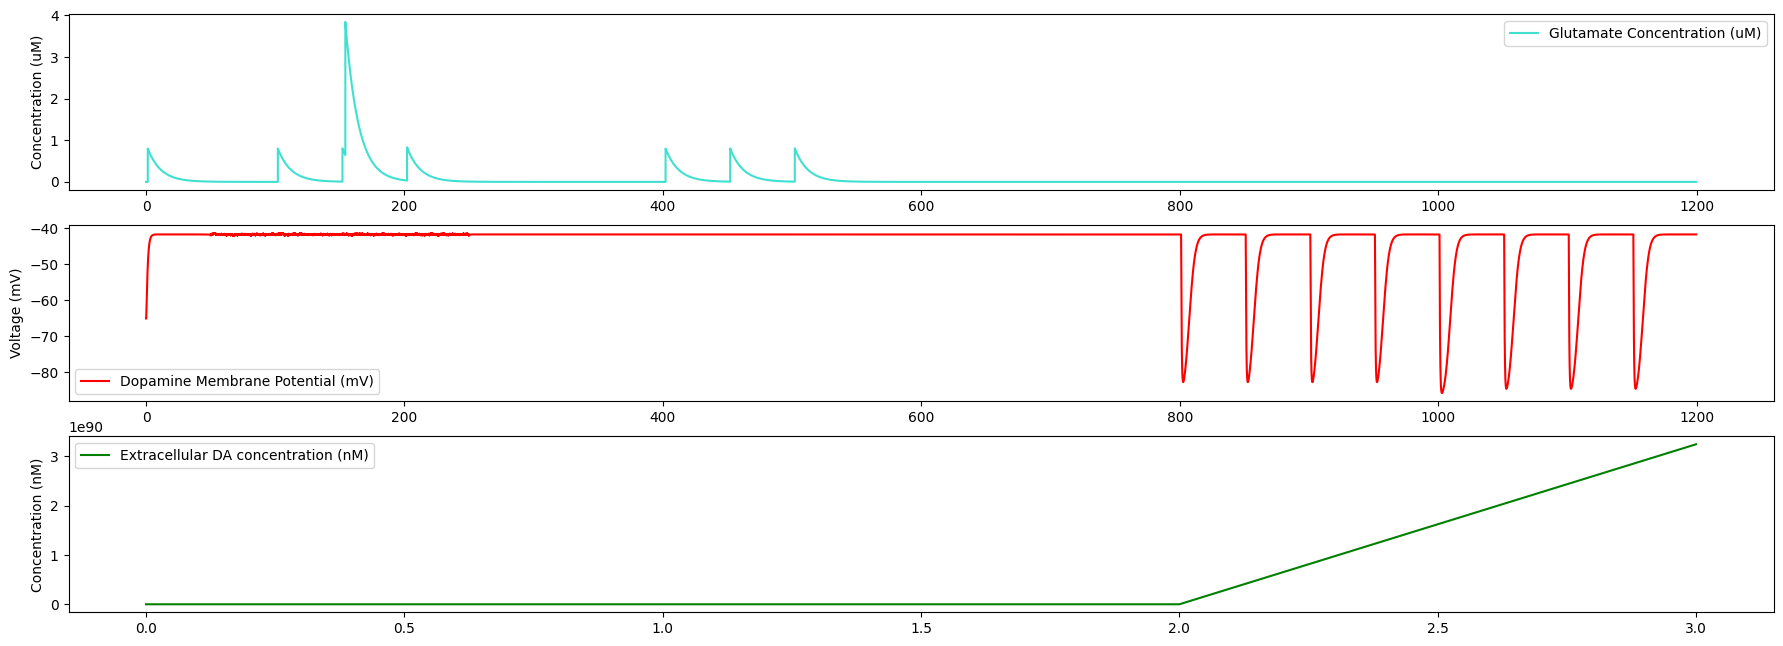

In [16]:
plt.figure(figsize=(22, 16))

plt.subplot(6, 1, 1)
plt.plot(t, glutamate_conc, label="Glutamate Concentration (uM)", color = "turquoise")
plt.ylabel("Concentration (uM)")
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(t, v_dop, label="Dopamine Membrane Potential (mV)", color = "red")
plt.ylabel("Voltage (mV)")
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(np.arange(0, 1200, 1), daEX_list, label="Extracellular DA concentration (nM)", color = "green")
plt.ylabel("Concentration (nM)")
plt.legend()